## Imports

In [1]:
# Imports
import wikipedia
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import re
import requests
from bs4 import BeautifulSoup

## Functions

In [228]:
help_link_regex = re.compile("^/wiki/Help:")


# Gets the "first link" from a wikipedia page using the full URL
# Help from https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_first_link(page_url, help_link_regex=help_link_regex):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")

    # Many pages lack a first link or have a strange structure requiring a lot of try statements
    try:
        # Paragraphs of the page
        paragraphs = (
            soup.find(id="mw-content-text").find(class_="mw-parser-output").find_all("p", recursive=False)
        )

        # Find all links in the first paragraph
        if len(paragraphs) > 5:
            filtered_paragaphs = [p for p in paragraphs[:4] if len(p) > 1]
        else:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]

        link_list = []

        for p in filtered_paragaphs:
            p_links = p.find_all("a")
            # Leave them out if they match the previous RegEx
            for link in p_links:
                if not help_link_regex.match(link.get("href")):
                    href = str(link.get("href"))
                    link_class = str(link.get("class"))
                    # print(link_class)

                    # Pages that start with # wrongly redirect to the homepage
                    if href.startswith('#'):
                        href = href.lstrip("#")

                    # Filters out bad links in wikipedia pages
                    if (
                        href != None
                        and not href.endswith('.ogg')
                        and not href.endswith("Wikipedia:Please_clarify")
                        and "#cite_note" not in href
                        and "upload.wikimedia.org" not in href
                        and link_class != "['extiw']"
                        and not href.startswith("file:")
                        and not href.startswith("https://geohack.toolforge.org/")
                        and not href.startswith("special:")
                        and not href.startswith("/w/index.php?")
                        and not href.startswith("cite_note")
                    ):
                        link_list.append(href)
                        break
            try:
                first_link = link_list[0]

                # Cleaning the name
                if '/wiki/' in first_link:
                    first_link_output = first_link.split("/wiki/", 1)[1]
                else:
                    first_link_output = first_link
                return first_link_output

            # If it has no links, it is disconnected
            except IndexError:
                # NO LINKS
                original_name = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
                return original_name

    # These errors get manually checked
    except (AttributeError, TypeError) as error:
        # NO LINKS
        fail_output = "!FAIL!: " + page_url
        return fail_output


In [213]:
# Testing the function. It should be 'Private_university'
get_first_link("https://en.wikipedia.org/wiki/georgetown_university")

'Private_university'

In [219]:
help_link_regex = re.compile("^/wiki/Help:")


# Gets the "second link" from a wikipedia page using the full URL
# The same as the first link function it just gets the second link
# Help from https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_second_link(page_url, help_link_regex=help_link_regex):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")

    # Many pages lack a first link or have a strange structure requiring a lot of try statements
    try:
        # Paragraphs of the page
        paragraphs = (
            soup.find(id="mw-content-text").find(class_="mw-parser-output").find_all("p", recursive=False)
        )

        # Find all links in the first paragraph
        if len(paragraphs) > 5:
            filtered_paragaphs = [p for p in paragraphs[:4] if len(p) > 1]
        else:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]

        link_list = []

        for p in filtered_paragaphs:
            p_links = p.find_all("a")
            # Leave them out if they match the previous RegEx
            for link in p_links:
                if not help_link_regex.match(link.get("href")):
                    href = str(link.get("href"))
                    link_class = str(link.get("class"))
                    # print(link_class)

                    # Pages that start with # wrongly redirect to the homepage
                    if href.startswith('#'):
                        href = href.lstrip("#")

                    # Filters out bad links in wikipedia pages
                    if (
                        href != None
                        and not href.endswith('.ogg')
                        and not href.endswith("Wikipedia:Please_clarify")
                        and "#cite_note" not in href
                        and "upload.wikimedia.org" not in href\
                        # and link_class != "['mw-redirect']" # Redirects don't work since it returns a blank HTML
                        and link_class != "['extiw']"
                        and not href.startswith("file:")
                        and not href.startswith("https://geohack.toolforge.org/")
                        and not href.startswith("special:")
                        and not href.startswith("/w/index.php?")
                        and not href.startswith("cite_note")
                    ):
                        link_list.append(href)

                        if len(link_list) > 2:
                            break
            try:
                first_link = link_list[1]

                # Cleaning the name
                if '/wiki/' in first_link:
                    first_link_output = first_link.split("/wiki/", 1)[1]
                else:
                    first_link_output = first_link
                return first_link_output

            # If it has no links, it is disconnected
            except IndexError:
                # NO LINKS
                original_name = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
                return original_name

    # These errors get manually checked
    except (AttributeError, TypeError) as error:
        # NO LINKS
        fail_output = "!FAIL!: " + page_url
        return fail_output


In [232]:
# Testing the function. It should be 'Society_of_Jesus'
get_second_link("https://en.wikipedia.org/wiki/georgetown_university")

'Society_of_Jesus'

In [207]:
# Function that computes how far the average page is from the Philosophy page
import statistics
def avg_dist_from_phil(G):
    distance_from_phil = []

    # Get nodes connected to "philosophy"
    connected_nodes = [node for node in G.nodes if nx.has_path(G, node, "philosophy")]

    for node in connected_nodes:

        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        distance_from_phil.append(shortest_path_length)

    # Return the mean
    return statistics.mean(distance_from_phil)


In [6]:
# Function that finds a new random page on Wikipedia
def wiki_random_page(seen_pages):

    # Set up while loop that searches 
    already_seen_page = True

    while already_seen_page:

        # Use the wikipedia api to find a random page
        random_page = wikipedia.random()
        
        # If it has already seen the page, go back up and try again
        if random_page in seen_pages:
            already_seen_page = True
            continue

        # Ignoring pages that are just lists of other pages and disambiguation because they are not 'real' wikipedia pages used for understanding a topic
        elif "list of " in random_page.lower() or "list_of" in random_page.lower():
            already_seen_page = True
        
        elif '(disambiguation)' in random_page.lower():
            already_seen_page = True

        # If it is a new page, return the page and its url
        else:
            page_url = "https://en.wikipedia.org/wiki/" + random_page.replace(" ", "_")
            already_seen_page = False

    return random_page, page_url

In [8]:
# Testing the function
seen_pages = ['philosophy']
wiki_random_page(seen_pages)

('Heroic Origins', 'https://en.wikipedia.org/wiki/Heroic_Origins')

## Creating the First-Link Network

In [175]:
# Create Graph
G = nx.DiGraph()

# Add Philosophy as the first node
G.add_node("philosophy")

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
seed_page = seed_page.replace(" ", "_").lower()
is_root = True

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
seen_pages = ["philosophy"]

# List of fails
fails = []

# Not connected to philosophy
disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
convergence_df = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree", "avg_dist_from_phil"])

In [234]:
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):

    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # From experience, these are the most notable pages I want to focus on. If their centrality has converged, we can stop expanding the network
    notable_nodes = ["philosophy", "awareness", "knowledge", "science", "language", "philosophy_of_logic"]

    # Remove the link extra to get a cleaner page name
    root_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
    
    # Pretty display of function progress 
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="Green", ncols=75):
        # Get the first link
        # print(page_url)
        full_first_link = get_first_link(page_url=page_url)

        if full_first_link is None:
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it has nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(full_first_link)
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                is_root = True
                continue

        # Get the cleaner name for the node
        first_link = full_first_link.lower()
        # print(first_link)

        # If it fails, find try a new random page
        if "!FAIL!: " in str(full_first_link):
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(first_link)
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                is_root = True
                continue
                
        elif "DEAD END: " in str(full_first_link):
            # print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            continue

        # Add node
        G.add_node(first_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, first_link)
        
        # Every 100 iterations, once all of the notable nodes have been hit, check their key statistics
        if i % 100 == 0 and all([True if node in G.nodes else False for node in notable_nodes]):

            # Calculate values
            new_between_cent = {node: val for node, val in nx.betweenness_centrality(G, endpoints='philosophy').items() if node in notable_nodes}
            new_closeness_cent = {node: val for node, val in nx.closeness_centrality(G).items() if node in notable_nodes}
            new_in_degree_cent = {node: val for node, val in nx.in_degree_centrality(G).items() if node in notable_nodes}
            
            # Calculate average distance
            new_avg_dist = avg_dist_from_phil(G)

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node], new_avg_dist]
                convergence_df.loc[len(convergence_df.index)] = new_row


        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a self loop! Not connected to philosophy
        elif first_link == root_page:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/wiki/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


In [210]:
# Running the function
G, seen_pages, fails, disconnects, convergence_df = network_expander(
    G,
    page_url=first_page_url,
    seen_pages=seen_pages,
    is_root=True,
    fails=fails,
    disconnects=disconnects,
    convergence_df=convergence_df,
    new_pages=100,
)

Finding Paths: 100%|██████████████████████████████████████████████| 100/100


In [211]:
fails

['file:ll-q150_(fra)-grandcelinien-ain.wav',
 'file:tatra-mountains-english.wav',
 'https://geohack.toolforge.org/geohack.php?pagename=crescent_arts_centre&params=54.5878_n_5.9352_w_region:gb_scale:10000',
 'file:ll-q14196_(afr)-oesjaar-pretoria.wav',
 'https://geohack.toolforge.org/geohack.php?pagename=kardzhali_province&params=41_39_n_25_22_e_type:adm1st_region:bg-11_dim:50000_source:dewiki',
 'file:ll-q1860_(eng)-vealhurl-eritrea.wav',
 '#source_and_target_languages',
 'https://geohack.toolforge.org/geohack.php?pagename=alsace&params=48_30_n_7_30_e_region:fr_type:adm1st',
 'file:es-colombia2.oga',
 'file:montreal-english-pronunciation.oga',
 'https://geohack.toolforge.org/geohack.php?pagename=lake_county,_florida&params=28.77_n_81.72_w_type:adm2nd_region:us-fl_source:uscensus1990',
 'file:cymraeg_(cropped).wav',
 'https://geohack.toolforge.org/geohack.php?pagename=bugatti&params=48_31_32_n_07_30_01_e_',
 'file:ll-q150_(fra)-wikilucas00-commune.wav',
 'file:ll-q150_(fra)-grandcelinie

In [200]:
# Viewing the Convergence DF
convergence_df

,iteration,node,betweeness_centrality,closeness_centrality,in_degree,avg_dist_from_phil
0,50,philosophy,0.018174,0.131978,0.063830,6.452381
1,50,awareness,0.013741,0.059840,0.021277,6.452381
2,50,knowledge,0.019504,0.064157,0.042553,6.452381
3,50,science,0.017287,0.038298,0.021277,6.452381
4,50,language,0.015071,0.034043,0.021277,6.452381
...,...,...,...,...,...,...
3283,6390,awareness,0.000059,0.024831,0.000270,11.245021
3284,6390,knowledge,0.000052,0.019145,0.000675,11.245021
3285,6390,science,0.000047,0.013574,0.001754,11.245021
3286,6390,language,0.000223,0.033939,0.002294,11.245021


In [ ]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # Making sure it worked
    try:
        nx.shortest_path(G, fail, "philosophy")

    except nx.NodeNotFound:
        print("FAILED")

    return G, seen_pages

In [ ]:
G, seen_pages = fail_fixer(G, fail='!fail!: crime city', next_link="crime_film", seen_pages=seen_pages)

In [177]:
# Saving the network and DataFrame
first_link_path = './data/first-links-10000.gml'
nx.write_gml(G, first_link_path)

convergence_df.to_csv("./data/convergence_data-10000.csv")

In [243]:
# Create Second-Link Graph
G2 = nx.DiGraph()

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
seed_page = seed_page.replace(" ", "_").lower()
is_root = True

# Adding first node
G2.add_node(seed_page)

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
second_link_seen_pages = [seed_page]

# List of fails
second_link_fails = []

# Dead ends: pages with no second link
second_link_disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
# This one does not have an average distance from philosophy as there is no guarantee we even hit that page
convergence_df2 = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree"])

## Creating the Second Link Network

In [247]:
import heapq
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def second_link_network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):

    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # Remove the link extra to get a cleaner page name
    root_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
    
    # Pretty display of function progress 
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="Green", ncols=75):
        first_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
        pages_hit = [first_page]

        # Get the second link
        # print(page_url)
        full_second_link = get_second_link(page_url=page_url)

        if full_second_link is None:
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it has nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(full_second_link)
                # print(full_second_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_second_link = get_second_link(page_url=page_url)
                is_root = True
                continue

         # Get the cleaner name for the node
        second_link = full_second_link.lower()

        # If it fails, find try a new random page
        if "!FAIL!: " in str(full_second_link):
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(second_link)
                # print(full_second_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_second_link = get_second_link(page_url=page_url)
                is_root = True
                continue
                
        elif "DEAD END: " in str(full_second_link):
            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            continue

        # Add node
        G.add_node(second_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, second_link)
        
        # Every 100 iterations check the top 5 in key statistics
        if i % 100 == 0:

            # Calculate values
            new_between_cent = {node: val for node, val in nx.betweenness_centrality(G, endpoints='philosophy').items()}
            new_closeness_cent = {node: val for node, val in nx.closeness_centrality(G).items()}
            new_in_degree_cent = {node: val for node, val in nx.in_degree_centrality(G).items()}
            
            # Get the top 5 nodes for each centrality measure
            top_3_between = heapq.nlargest(3, new_between_cent, key=new_between_cent.get)
            top_3_closeness = heapq.nlargest(3, new_closeness_cent, key=new_closeness_cent.get)
            top_3_in_degree = heapq.nlargest(3, new_in_degree_cent, key=new_in_degree_cent.get)

            # Combine all top 5 nodes into a single list
            notable_nodes = top_3_between + top_3_closeness + top_3_in_degree           

            # Remove duplicates by converting to a set and back to a list
            notable_nodes = list(set(notable_nodes))

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node]]
                convergence_df.loc[len(convergence_df.index)] = new_row

        # If we have already seen where it goes, new root page
        if second_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a loop! No need to keep repeating it
        elif second_link in pages_hit:
            disconnects.append(root_page)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/wiki/" + full_second_link
            seen_pages.append(second_link)
            pages_hit.append(second_link)
            old_page = second_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


In [248]:
# Running the function
G2, second_link_seen_pages, second_link_fails, second_link_disconnects, convergence_df2 = second_link_network_expander(
    G2,
    page_url=first_page_url,
    seen_pages=second_link_seen_pages,
    is_root=True,
    fails=second_link_fails,
    disconnects=second_link_disconnects,
    convergence_df=convergence_df2,
    new_pages=500,
)

Finding Paths: 100%|██████████████████████████████████████████████| 500/500


In [251]:
# Saving the network and DataFrame
second_link_path = './data/second-links.gml'
nx.write_gml(G2, second_link_path)

convergence_df.to_csv("./data/second-link-convergence-data.csv")

## Analysis

### First Link Convergence

In [164]:
# Reading the data in
first_link_path = './data/first-links.gml'
G = nx.read_gml(first_link_path)

convergence_df = pd.read_csv("./data/convergence_data.csv")
convergence_df.pop("Unnamed: 0")
convergence_df.head()

,iteration,node,betweeness_centrality,closeness_centrality,in_degree,avg_dist_from_phil
0,50,philosophy,0.015957,0.103663,0.042553,7.189189
1,50,awareness,0.015514,0.079856,0.021277,7.189189
2,50,knowledge,0.022163,0.090780,0.042553,7.189189
3,50,science,0.020833,0.067749,0.042553,7.189189
4,50,language,0.039894,0.039280,0.021277,7.189189


In [202]:
total_iterations = max(convergence_df['iteration'])
last_1000_iterations = convergence_df[convergence_df["iteration"] >= total_iterations - 1000]
last_1000_iterations.reset_index(inplace=True)
last_1000_iterations.head()

,index,iteration,node,betweeness_centrality,closeness_centrality,in_degree,avg_dist_from_phil
0,2094,8975,philosophy,0.000105,0.047986,0.001784,11.016486
1,2095,8975,awareness,0.000090,0.026467,0.000396,11.016486
2,2096,8975,knowledge,0.000081,0.021137,0.000991,11.016486
3,2097,8975,science,0.000074,0.015036,0.002180,11.016486
4,2098,8975,language,0.000329,0.034465,0.003171,11.016486


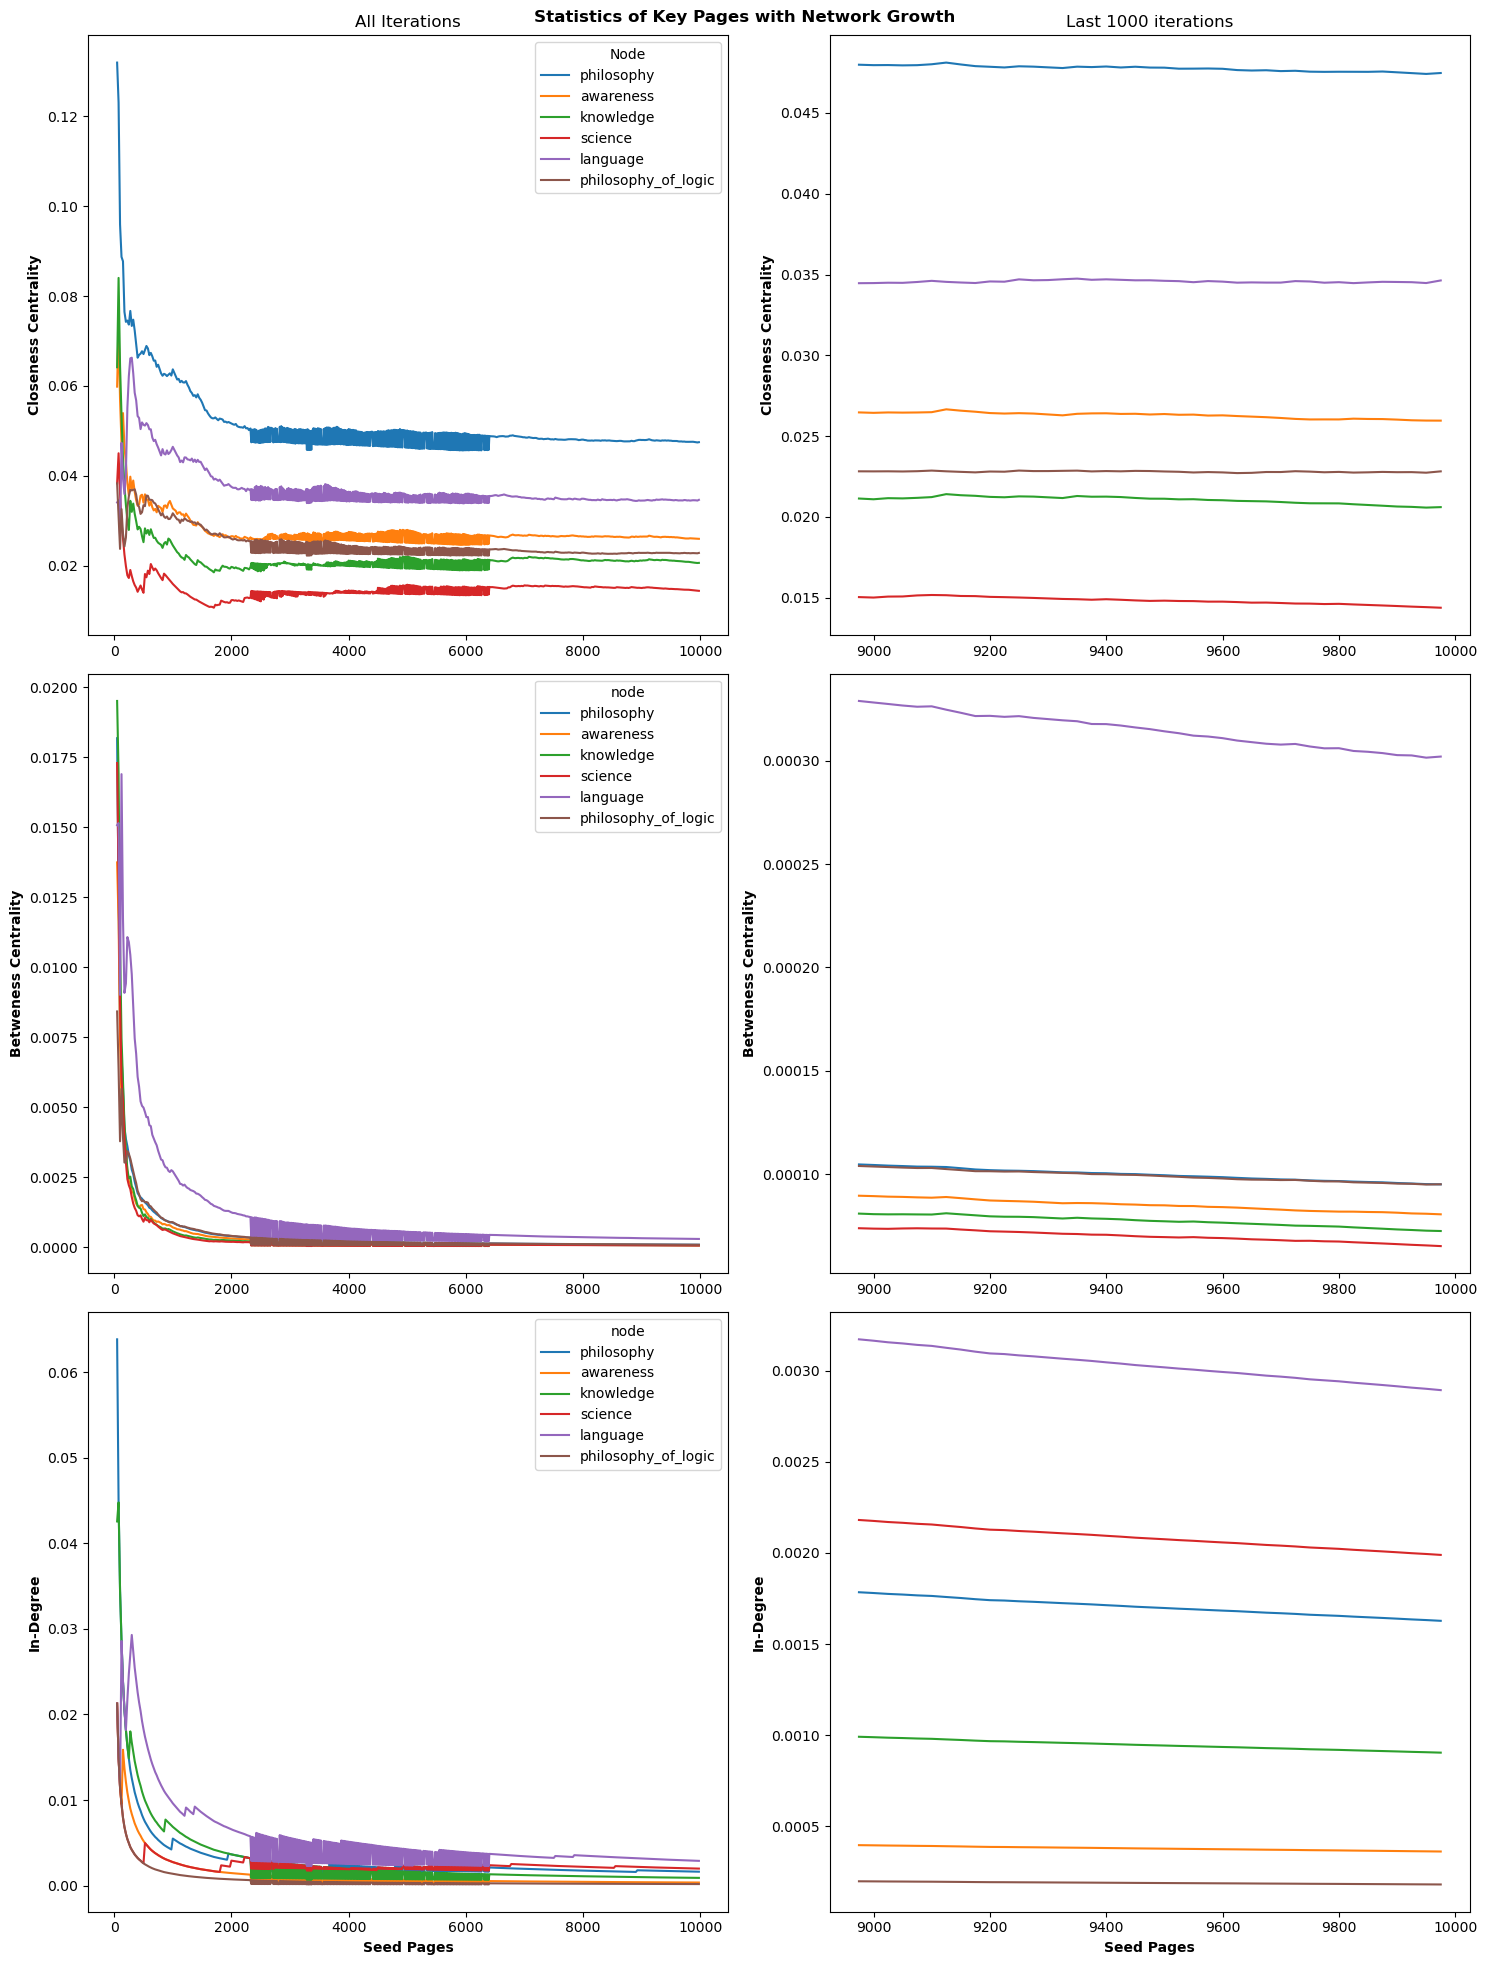

In [268]:
import seaborn as sns
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
sns.lineplot(convergence_df, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,0])
axs[0,0].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,0].set_xlabel("")
axs[0,0].set_title("All Iterations")

legend = axs[0,0].legend()
legend.set_title("Node")

sns.lineplot(last_1000_iterations, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,1], legend=False)
axs[0,1].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,1].set_xlabel("")
axs[0,1].set_title("Last 1000 iterations")

sns.lineplot(convergence_df, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,0])
axs[1,0].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,0].set_xlabel("")


sns.lineplot(last_1000_iterations, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,1], legend=False)
axs[1,1].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,1].set_xlabel("")

sns.lineplot(convergence_df, x="iteration", y="in_degree", hue="node", ax=axs[2,0])
axs[2,0].set_ylabel("In-Degree", fontweight='bold')
axs[2,0].set_xlabel("Seed Pages", fontweight='bold')

sns.lineplot(last_1000_iterations, x="iteration", y="in_degree", hue="node", ax=axs[2,1], legend=False)
axs[2,1].set_ylabel("In-Degree", fontweight='bold')
axs[2,1].set_xlabel("Seed Pages", fontweight='bold')


plt.suptitle("Statistics of Key Pages with Network Growth", fontweight='bold')
plt.tight_layout()

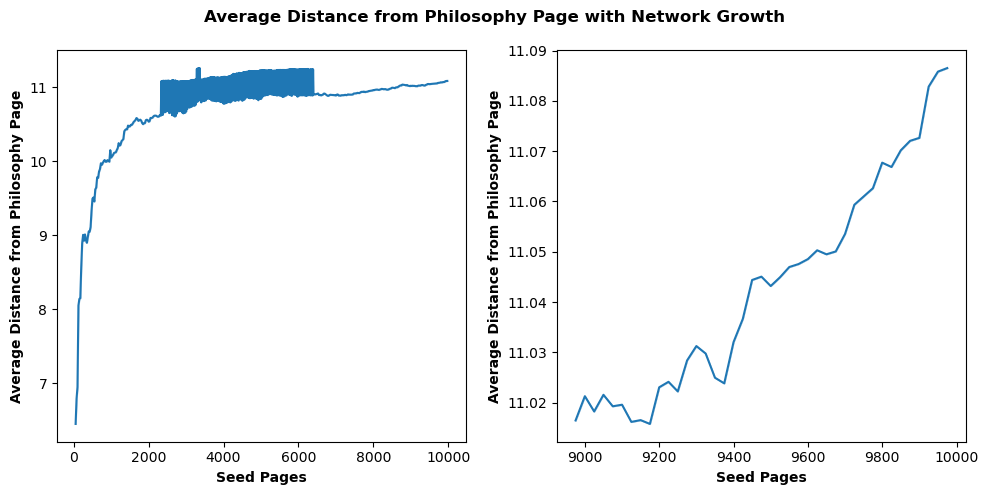

In [269]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(convergence_df, x="iteration", y="avg_dist_from_phil", ax=ax1)
ax1.set_ylabel("Average Distance from Philosophy Page", fontweight="bold")
ax1.set_xlabel("Seed Pages", fontweight="bold")


sns.lineplot(last_1000_iterations, x="iteration", y="avg_dist_from_phil", ax=ax2, legend=False)
ax2.set_ylabel("Average Distance from Philosophy Page", fontweight="bold")
ax2.set_xlabel("Seed Pages", fontweight="bold")


plt.suptitle("Average Distance from Philosophy Page with Network Growth", fontweight="bold")
plt.tight_layout()

In [ ]:
# Reading the data in
second_link_path = './data/second-links.gml'
G2 = nx.read_gml(second_link_path)

second_link_convergence_df = pd.read_csv("./data/second-link-convergence-data.csv")
second_link_convergence_df.pop("Unnamed: 0")
second_link_convergence_df.head()

In [270]:
second_link_total_iterations = max(convergence_df2['iteration'])
second_link_last_1000_iterations = convergence_df2[convergence_df2["iteration"] >= second_link_total_iterations - 1000]
second_link_last_1000_iterations.reset_index(inplace=True)
second_link_last_1000_iterations.head()

,index,iteration,node,betweeness_centrality,closeness_centrality,in_degree
0,0,0,society_of_jesus,0.000000,0.000000,0.000000
1,1,0,georgetown_university,0.000000,0.000000,0.000000
2,2,100,eukaryotic,0.033830,0.029639,0.011494
3,3,100,statistics,0.028736,0.024704,0.022989
4,4,100,population,0.035136,0.032251,0.011494


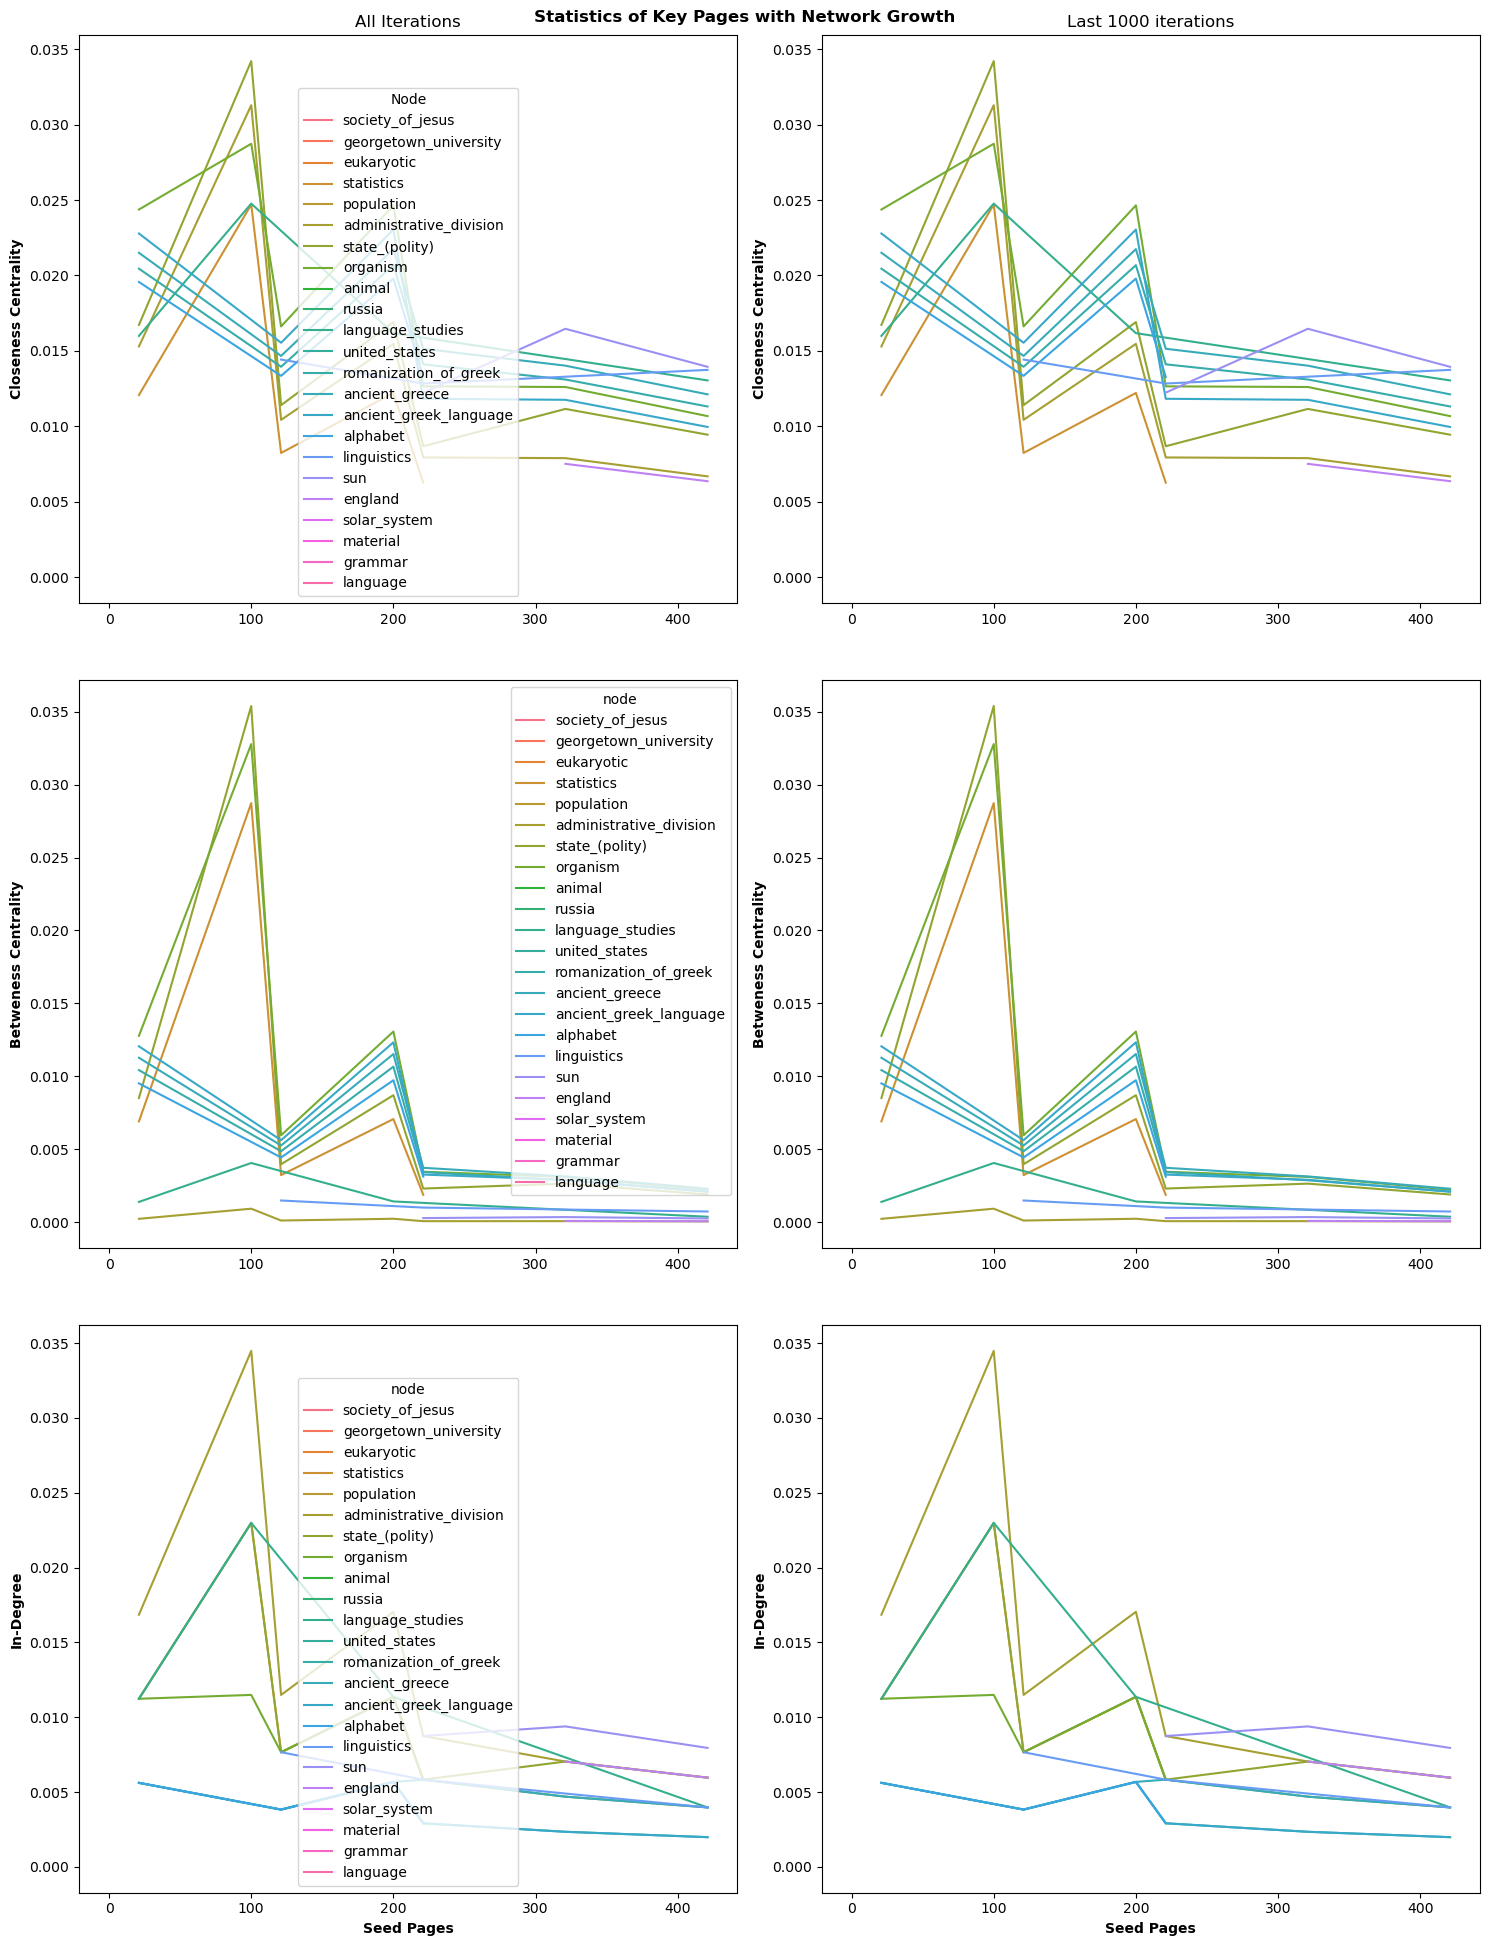

In [271]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
sns.lineplot(convergence_df2, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,0])
axs[0,0].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,0].set_xlabel("")
axs[0,0].set_title("All Iterations")

legend = axs[0,0].legend()
legend.set_title("Node")

sns.lineplot(second_link_last_1000_iterations, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,1], legend=False)
axs[0,1].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,1].set_xlabel("")
axs[0,1].set_title("Last 1000 iterations")

sns.lineplot(convergence_df2, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,0])
axs[1,0].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,0].set_xlabel("")


sns.lineplot(second_link_last_1000_iterations, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,1], legend=False)
axs[1,1].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,1].set_xlabel("")

sns.lineplot(convergence_df2, x="iteration", y="in_degree", hue="node", ax=axs[2,0])
axs[2,0].set_ylabel("In-Degree", fontweight='bold')
axs[2,0].set_xlabel("Seed Pages", fontweight='bold')

sns.lineplot(second_link_last_1000_iterations, x="iteration", y="in_degree", hue="node", ax=axs[2,1], legend=False)
axs[2,1].set_ylabel("In-Degree", fontweight='bold')
axs[2,1].set_xlabel("Seed Pages", fontweight='bold')


plt.suptitle("Statistics of Key Pages with Network Growth", fontweight='bold')
plt.tight_layout()

Look into core decompositions for displaying the network. Force directed would be better but is slow. 
Switch it to a directed graph.

In [191]:
# ------------------------------
# NETWORK PLOTTING FUNCTION
# ------------------------------
def plot_network(G, node_color="degree", layout="random"):
    # INITALIZE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    # NODE COLORS
    cmap = plt.cm.get_cmap("Greens")

    # DEGREE
    if node_color == "degree":
        centrality = list(dict(nx.degree(G)).values())

    # BETWENNESS
    if node_color == "betweeness":
        centrality = list(dict(nx.betweenness_centrality(G, endpoints="philosophy")).values())

    # CLOSENESS
    if node_color == "closeness":
        centrality = list(dict(nx.closeness_centrality(G)).values())

    # NODE SIZE CAN COLOR
    node_colors = [cmap(u / (0.01 + max(centrality))) for u in centrality]
    node_sizes = [10000 * u / (0.001 + max(centrality)) for u in centrality]

    scaled_node_sizes = [size if size > 3000 else 100 for size in node_sizes]

    scale = [size / max(node_sizes) for size in scaled_node_sizes]

    # POSITIONS LAYOUT
    N = len(G.nodes)
    if layout == "spring":
        # pos=nx.spring_layout(G,k=50*1./np.sqrt(N),iterations=100)
        pos = nx.spring_layout(G, scale=scale)

    if layout == "random":
        pos = nx.random_layout(G)

    if layout == "spiral":
        pos = nx.spiral_layout(G, scale=scale)

    if layout == "spectral":
        pos = nx.spectral_layout(G, scale=scale)
    
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)

    # PLOT NETWORK
    nx.draw(
        G,
        edgecolors="black",
        node_color=node_colors,
        node_size=scaled_node_sizes,
        pos=pos,
        with_labels=True
    )

    plt.show()


# G.remove_edges_from(nx.selfloop_edges(G))
# plot_network(nx.k_core(G, 50), node_color="degree", layout="spectral")


In [183]:
degree_dict = dict(G.in_degree())

# Create a dataframe with nodes and their degrees
df_nodes = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])

# Sort the dataframe by degree in descending order
df_nodes_sorted = df_nodes.sort_values(by='Degree', ascending=False)

df_nodes_sorted.head(10)

,Degree
french_language,51
county_(united_states),43
british_english,38
spanish_language,35
german_language,33
u.s._state,31
american_english,29
public_university,28
biology,27
united_states,23


In [236]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # fails = fails[True if f[0]!=fail else False for f in fails]

    return G, seen_pages

In [133]:
disconnects

[]

In [29]:
# Calculate the degrees of each node
degrees = dict(G.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by degree:
french_language: 33
sport: 25
german_language: 22
u.s._state: 20
physics: 18
biology: 17
family_(biology): 17
association_football: 17
public_university: 17
language: 16


In [184]:
# Calculate the degrees of each node
in_degree = dict(nx.in_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by in_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by in_degree:
french_language: 0.009204114780725501
county_(united_states): 0.007760332070023461
british_english: 0.006857967875834686
spanish_language: 0.006316549359321422
german_language: 0.005955603681645912
u.s._state: 0.005594658003970403
american_english: 0.005233712326294893
public_university: 0.005053239487457137
biology: 0.004872766648619383
united_states: 0.004150875293268363


In [185]:
# Calculate the degrees of each node
out_degree = dict(nx.out_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by out_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by out_degree:
private_university: 0.00018047283883775492
higher_education: 0.00018047283883775492
tertiary_education: 0.00018047283883775492
education: 0.00018047283883775492
knowledge: 0.00018047283883775492
awareness: 0.00018047283883775492
sicilian_language: 0.00018047283883775492
italian_language: 0.00018047283883775492
romance_languages: 0.00018047283883775492
modern_language: 0.00018047283883775492


In [186]:
neighbors = [n[0] for n in list(G.in_edges("philosophy"))]
neighbor_degrees = [G.in_edges(n) for n in neighbors]
neighbors

['awareness',
 'philosophy_of_logic',
 'aesthetics',
 'analytic_philosophy',
 'philosophy_of_culture',
 'object_(philosophy)',
 'metaphysics',
 'age_of_enlightenment',
 'medical_specialty']

In [187]:
# Calculate the degrees of each node
betweeness_centrality = dict(nx.betweenness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by betweeness centrality:")
for node, betweeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {betweeness_centrality}")

Top nodes by betweeness centrality:
language: 0.0002580044916236496
communication: 0.0002286857993936894
information: 0.00018855176736334392
abstraction: 0.00014239111526350662
greek_language: 0.00013079394367032236
ancient_greek: 0.00012235667557303383
modern_greek: 0.00011988087489583718
latin: 0.0001159717159318425
dialect: 0.0001114110304738487
geography: 0.00011010797748585046


In [188]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by closeness centrality:")
for node, closeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {closeness_centrality}")

Top nodes by closeness centrality:
philosophy: 0.0474479677596888
language: 0.03459360554355381
communication: 0.03273982583125381
information: 0.03041497538747914
abstraction: 0.02755837904286356
awareness: 0.025911380178882174
rule_of_inference: 0.024976735923118575
philosophy_of_logic: 0.022841376006301862
knowledge: 0.020567518532269426
branches_of_science: 0.01882452439965574


In [189]:
distance_from_phil = []
path_to_phil = []
nodes = []
for node in G.nodes:
    try:
        shortest_path = nx.shortest_path(G, node, "philosophy")
        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        nodes.append(node)
        distance_from_phil.append(shortest_path_length)
        path_to_phil.append(shortest_path)
    except nx.NetworkXNoPath:
        shortest_path = np.NAN
        shortest_path_length = np.NAN
        continue


# nodes  = [n for n in G.nodes]
df = pd.DataFrame(
    {"node": nodes, "distance": distance_from_phil, "shortest_path": path_to_phil}
)
print("AVERAGE DISTANCE TO PHILOSOPHY: ", np.mean(distance_from_phil))
df.sort_values("distance", inplace=True)
df.reset_index(inplace=True)
df.pop("index")
nodes = df["node"]
distances = df["distance"]
paths = df["shortest_path"]
print(
    "FURTHEST NODE: ",
    nodes[len(nodes) - 1],
    " is ",
    distances[len(distances) - 1],
    " pages away with a path of: ",
    paths[len(distances) - 1],
)
print(
    "THERE ARE "
    + str(
        sum([True if distance == max(distances) else False for distance in distances])
    )
    + " paths with a distance of "
    + str(max(distances))
)


AVERAGE DISTANCE TO PHILOSOPHY:  11.083676268861455
FURTHEST NODE:  manawat%c5%ab_district  is  25  pages away with a path of:  ['manawat%c5%ab_district', 'districts_of_new_zealand', 'new_zealand', 'm%c4%81ori_language', 'm%c4%81ori_people', 'indigenous_peoples_of_oceania', 'aboriginal_australians', 'indigenous_peoples', 'indigenous_peoples_of_the_americas', 'americas', 'north_america', 'continent', 'geography', 'ancient_greek', 'greek_language', 'modern_greek', 'dialect', 'latin', 'classical_language', 'language', 'communication', 'information', 'abstraction', 'rule_of_inference', 'philosophy_of_logic', 'philosophy']
THERE ARE 2 paths with a distance of 25


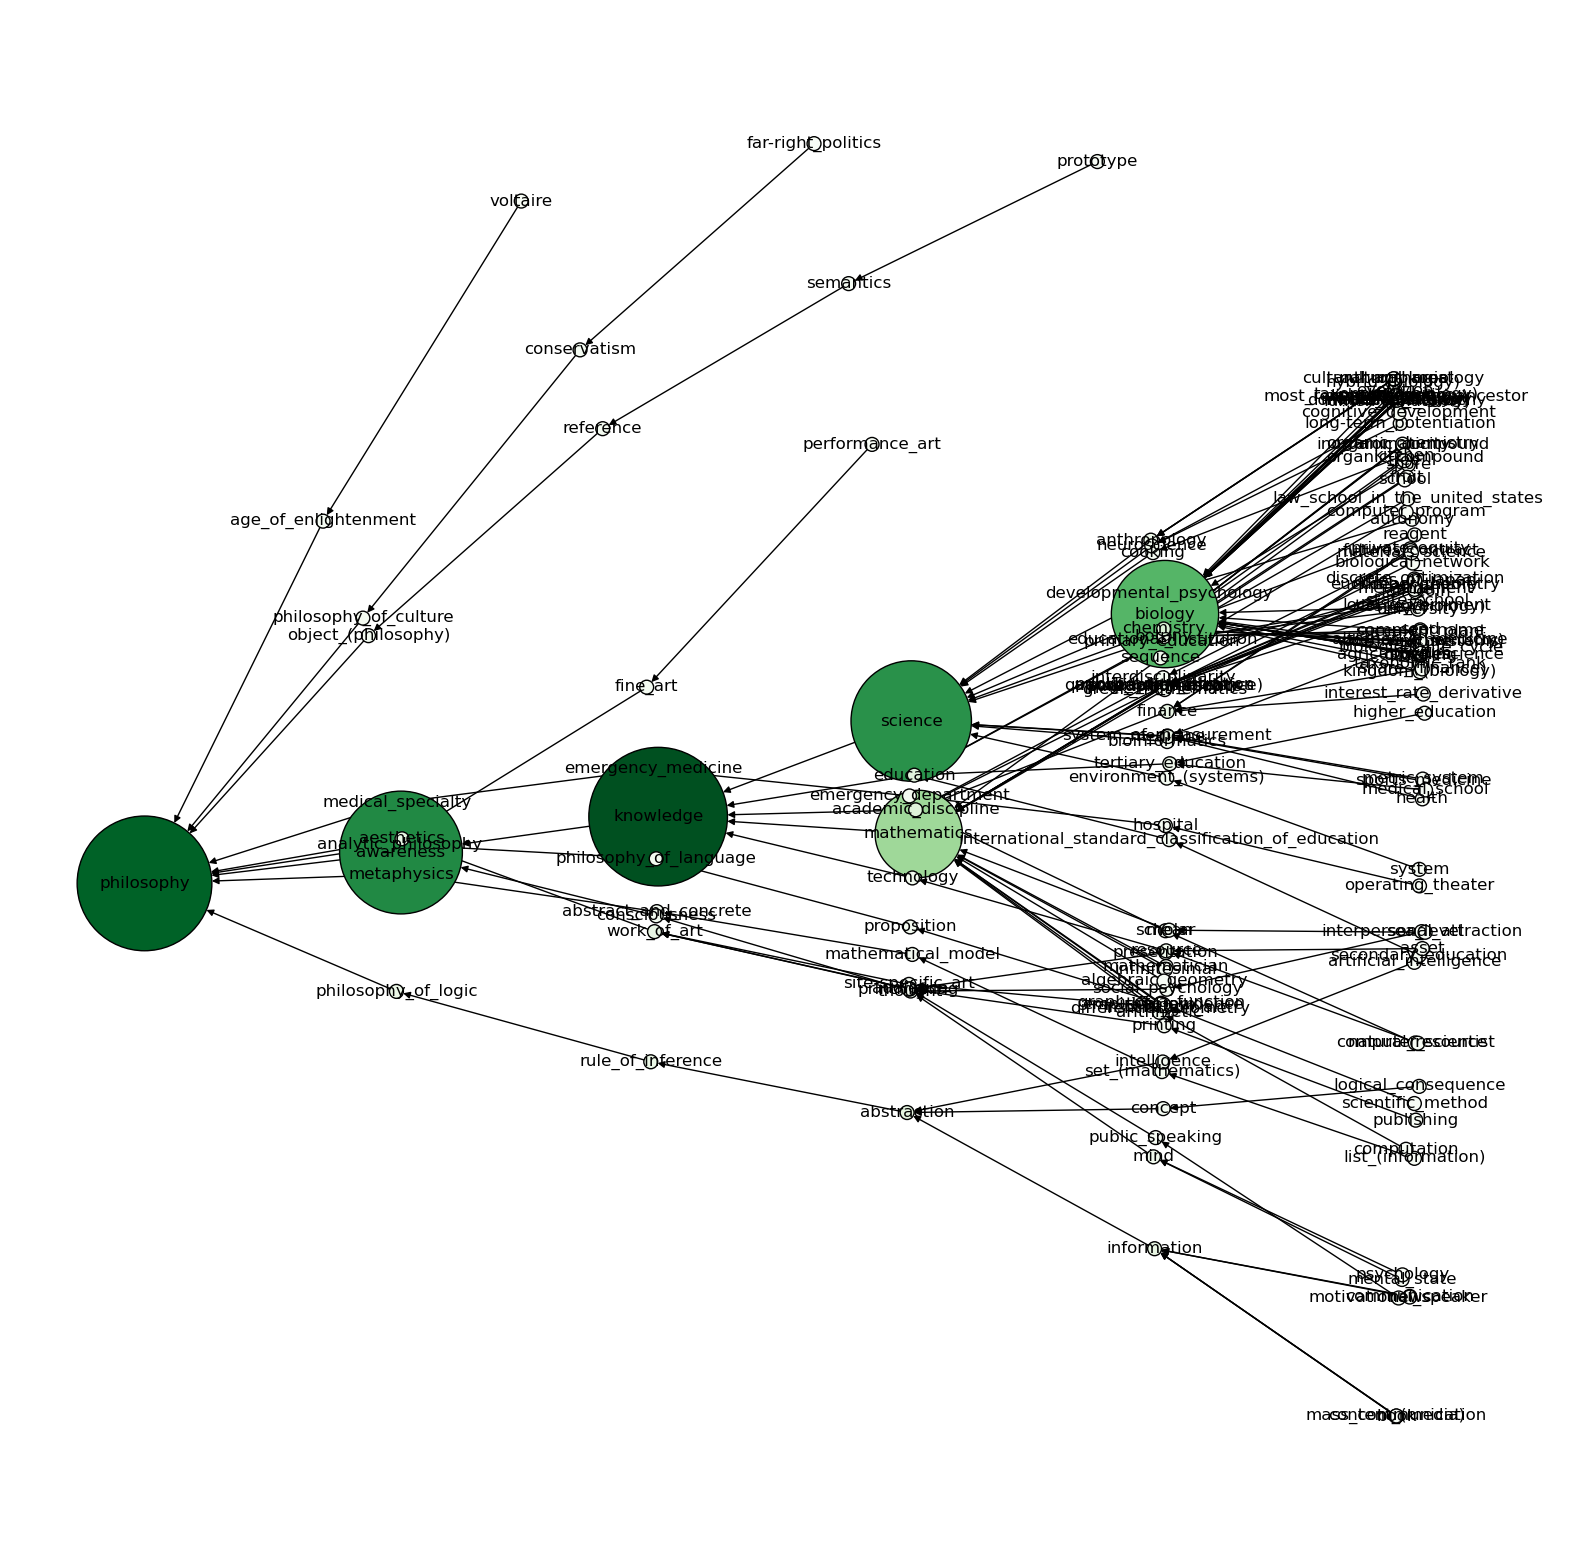

In [193]:
five_away = df[df['distance'] <= 5]

subgraph = G.subgraph(five_away['node'])

plot_network(subgraph, node_color="closeness", layout="kamada_kawai")

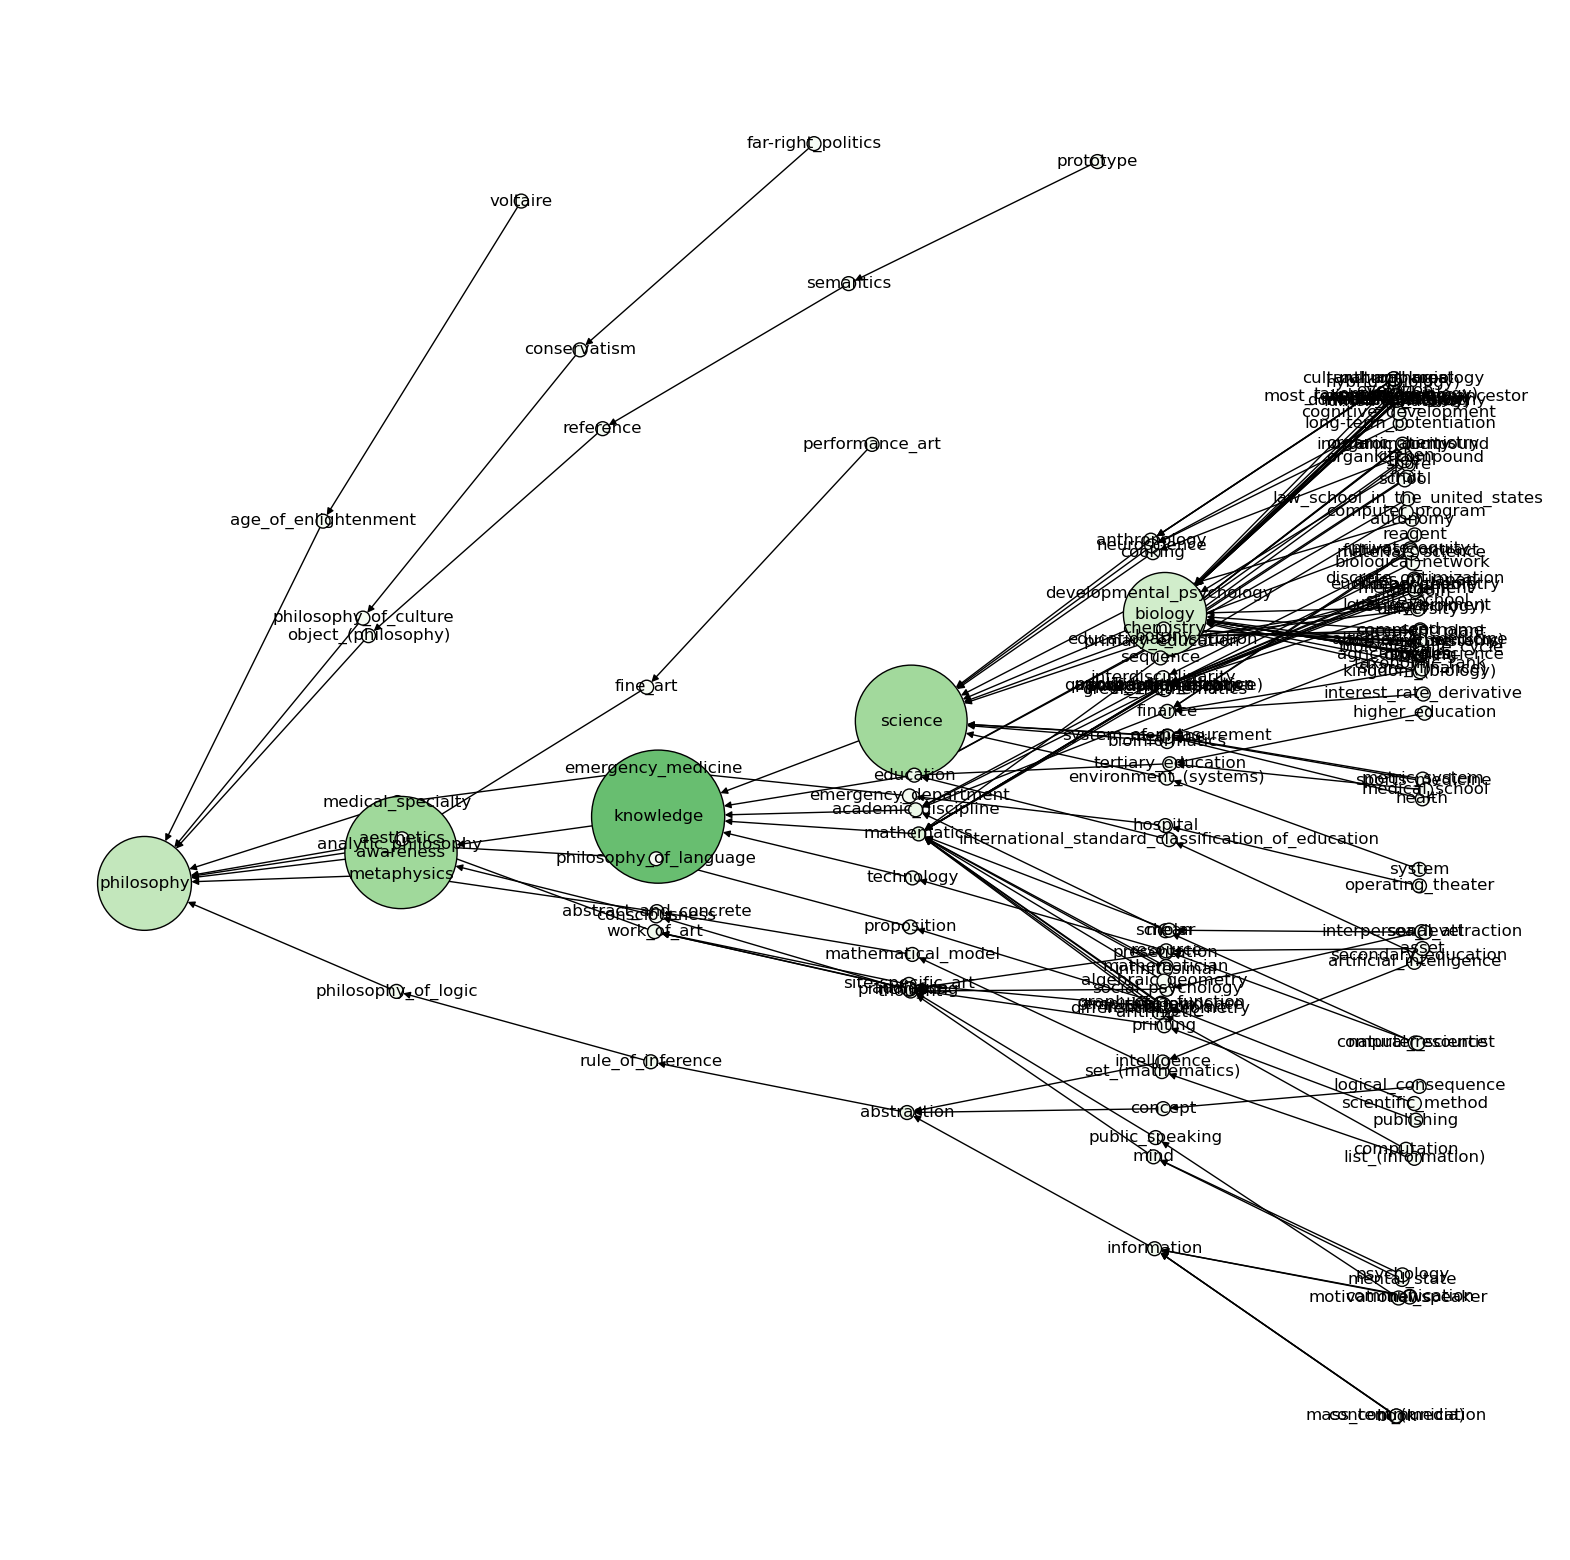

In [194]:
plot_network(subgraph, node_color="betweeness", layout="kamada_kawai")

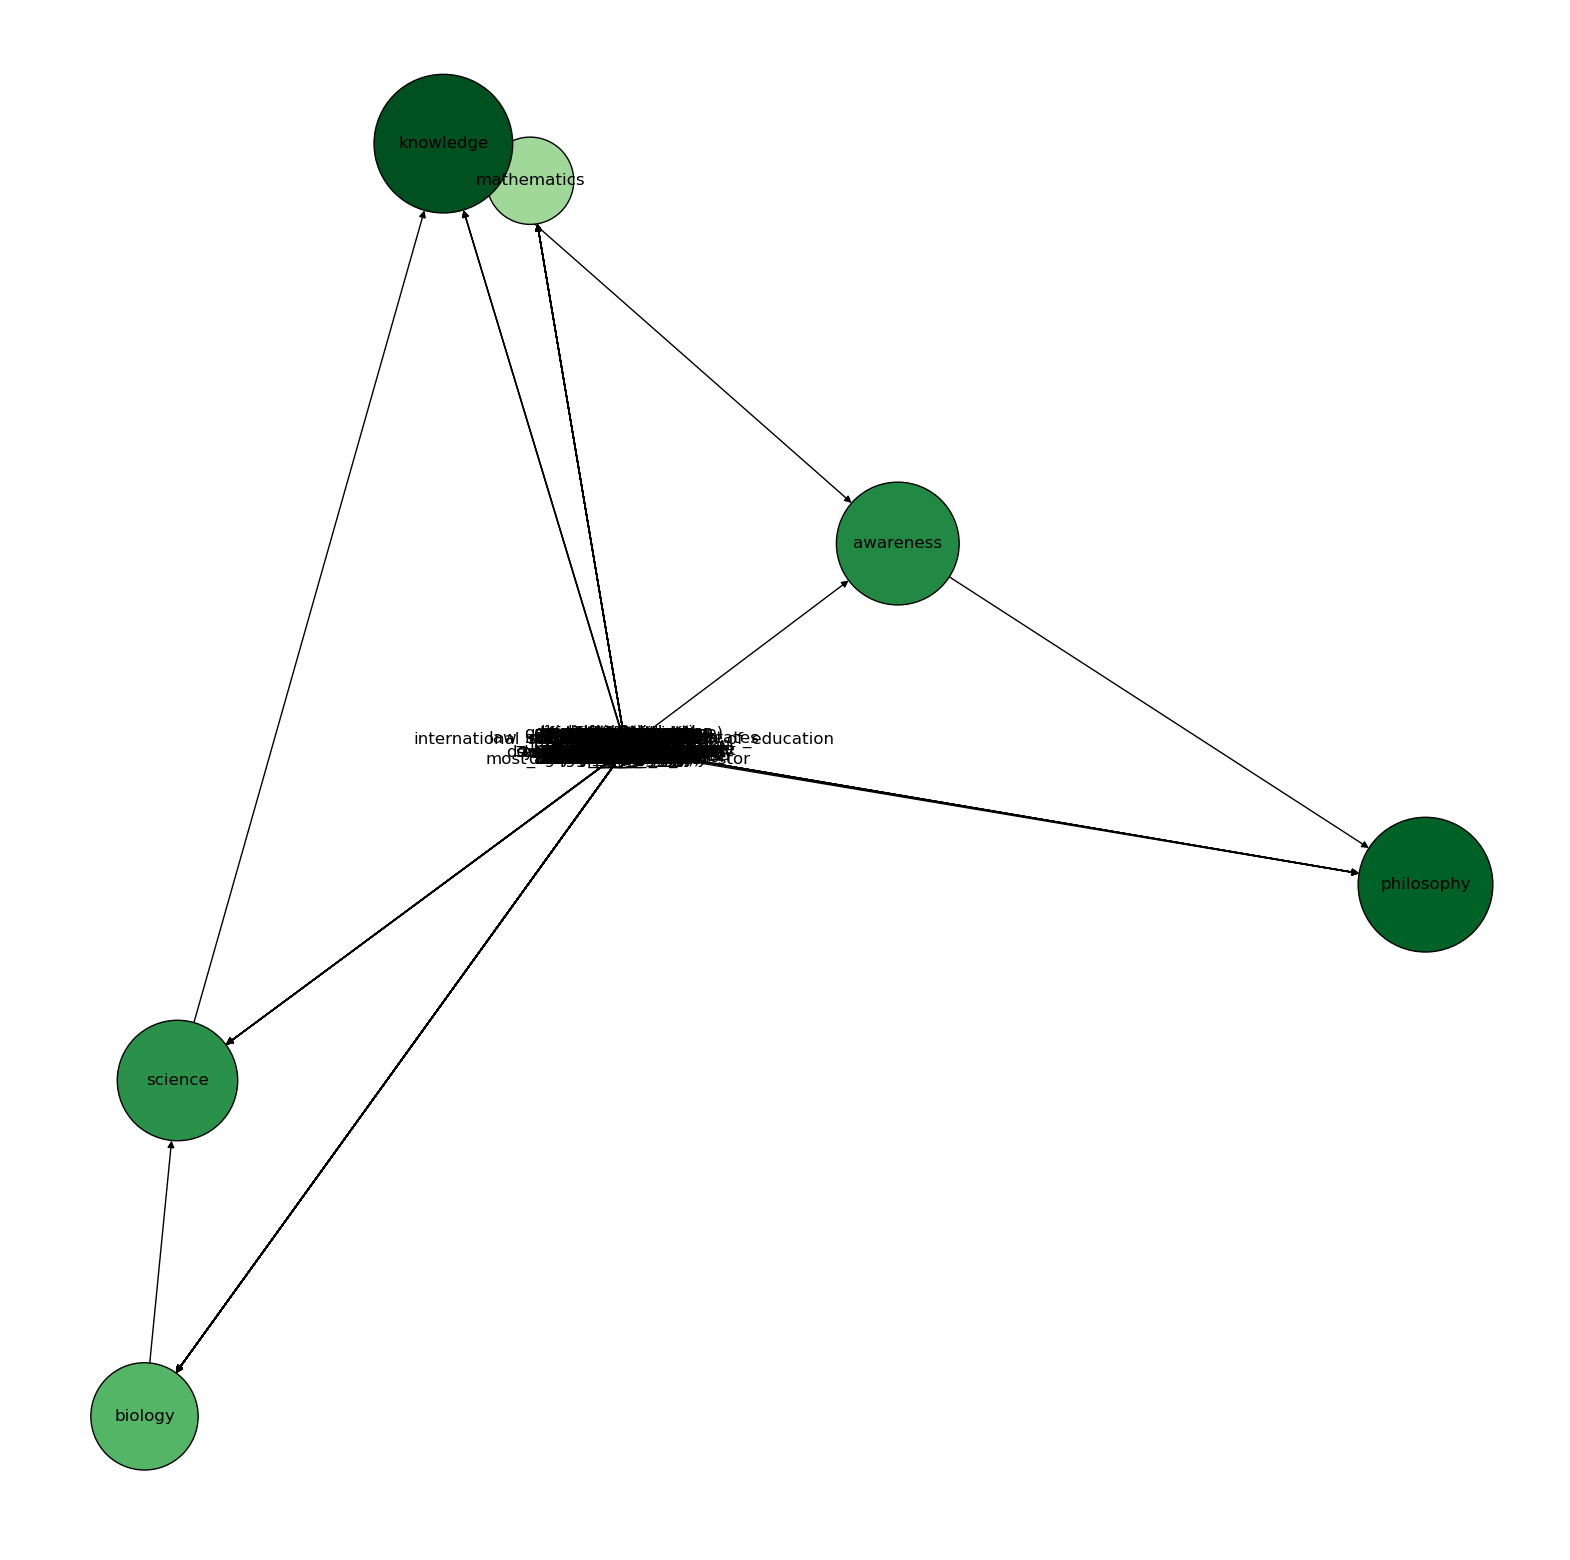

In [195]:
plot_network(subgraph, node_color="closeness", layout="spectral")

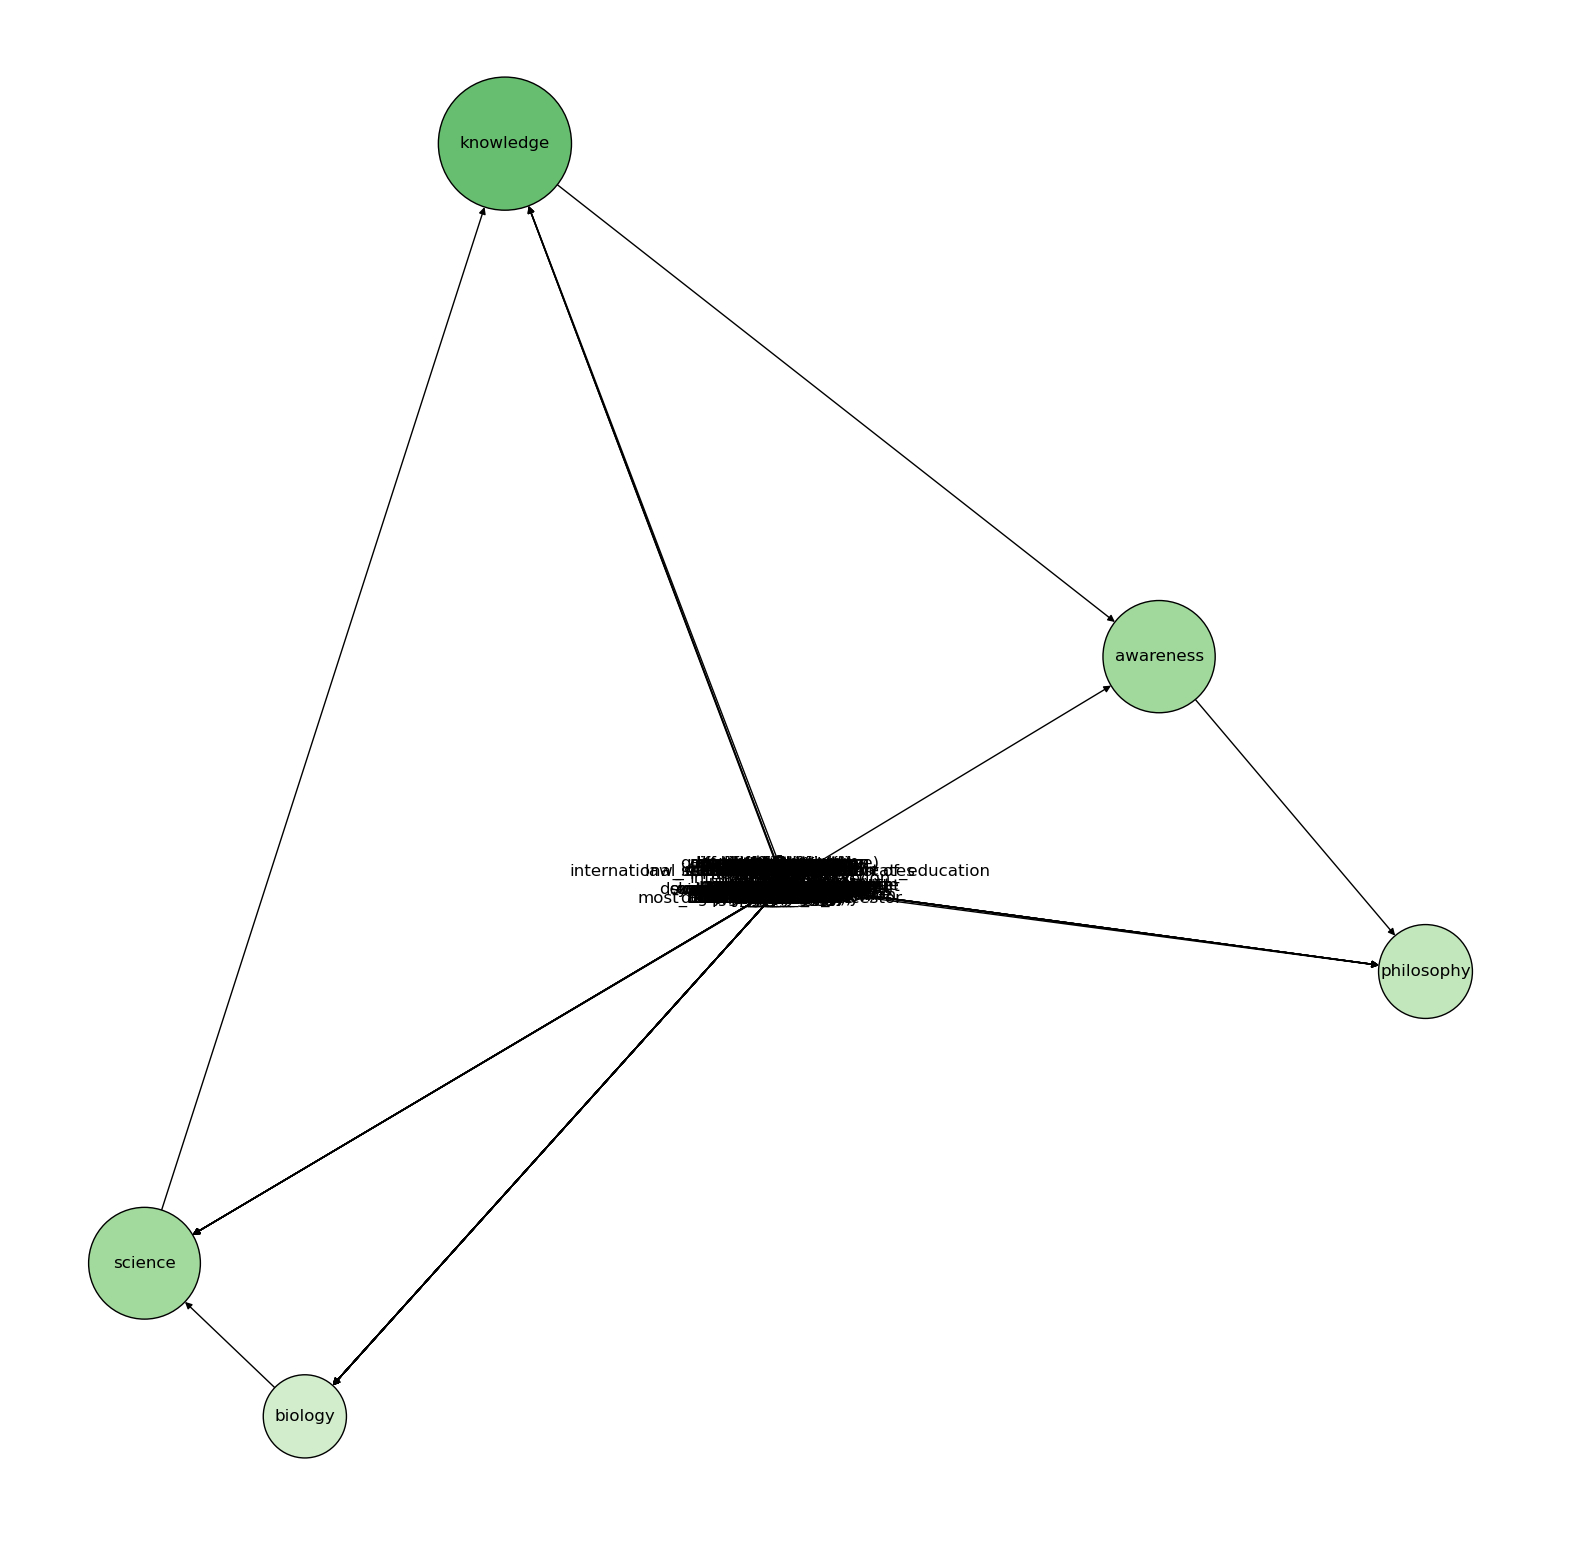

In [196]:
plot_network(subgraph, node_color="betweeness", layout="spectral")

In [197]:
path_appearances = []
for node in G.nodes:
    count = 0
    for path in paths:
        if node in path:
            count +=1
    
    path_appearances.append(count)

path_count_df = pd.DataFrame({"node":G.nodes, "appearances":path_appearances})
path_count_df = path_count_df.sort_values("appearances", ascending=False)
path_count_df.reset_index(inplace=True)
path_count_df.pop("index")

# Remove philosophy
path_count_df = path_count_df[1:]
path_count_df.head(80)

,node,appearances
1,philosophy_of_logic,1460
2,rule_of_inference,1459
3,abstraction,1458
4,information,1448
5,communication,1405
...,...,...
76,game,45
77,music_genre,45
78,fiction,44
79,indo-iranian_languages,43
